# Importing Libraries

Before we explore the data, let's import all sufficiencies that we'll need throughout the project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid',palette='viridis')

from wordcloud import WordCloud
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('wordnet')
import emoji
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Explanatory Data Analysis (EDA)

Let's now import and inspect our dataset with various methods, try to get more familiar with the data we will be working on

In [2]:
file_path_train = "data/raw/train.csv"
file_path_test = "data/raw/test.csv"

try:
  train = pd.read_csv(file_path_train)
  test = pd.read_csv(file_path_test)
  print("Train dataset shape:", train.shape)
  print("Test dataset shape:", test.shape)
  print("Train dataset head:", train.head())
  print("Test dataset head:", test.head())

except FileNotFoundError:
  print(f"Error: One or both of the files were not found at the specified paths.")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file(s). Please check the file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Train dataset shape: (40000, 2)
Test dataset shape: (10000, 2)
Train dataset head:                                               review sentiment
0  I caught this little gem totally by accident b...  positive
1  I can't believe that I let myself into this mo...  negative
2  *spoiler alert!* it just gets to me the nerve ...  negative
3  If there's one thing I've learnt from watching...  negative
4  I remember when this was in theaters, reviews ...  negative
Test dataset head:                                               review sentiment
0  Yes, MTV there really is a way to market Daria...  negative
1  The story of the bride fair is an amusing and ...  negative
2  A team varied between Scully and Mulder, two o...  positive
3  This was a popular movie probably because of t...  negative
4  This movie made me so angry!! Here I am thinki...  negative


In [3]:
train.head(10)

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative
5,Opera (the U.S. title is terror at the opera) ...,positive
6,Heard about this film a long while ago and fin...,positive
7,"John Holmes is so famous, he's infamous (as th...",positive
8,What is worth mentioning that is omitted in th...,positive
9,Darling Lili is fantastic! Its by far one my f...,positive


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [6]:
train.describe()

,review,sentiment
count,40000,40000
unique,39728,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,20000


Okay so we have 2 columns, review (review text of the movie) and sentiment (viewers sentiment from the text), which is binary. We got 40,000 instances, of which some seem to be duplicated and no Null values.

In [7]:
duplicate_reviews = train[train.duplicated(subset='review')]

print(f"Number of duplicate reviews: {duplicate_reviews.shape[0]}")

Number of duplicate reviews: 272


In [8]:
duplicate_reviews.head()

,review,sentiment
1700,There are plenty of comments already posted sa...,negative
2062,No one would ever question that director Leos ...,positive
2659,Well I guess I know the answer to that questio...,negative
3540,There's something frustrating about watching a...,negative
4176,Do we really need any more narcissistic garbag...,negative


In [9]:
train = train.drop_duplicates(subset='review', keep='first')

As I suspected we had some duplicated review cases, which I think is not a normal case because there is no logic there to be exactly the same reviews. As you can see we got rid of them using keep='first', which keeps the first review instance and removes other duplicats. I know that they could've had different sentiments and I should have checked it, but since there are so little cases (less than a 1%) deleting them like this would not cause any bias in the model.

Text(0.5, 1.0, 'Sentiment Distribution')

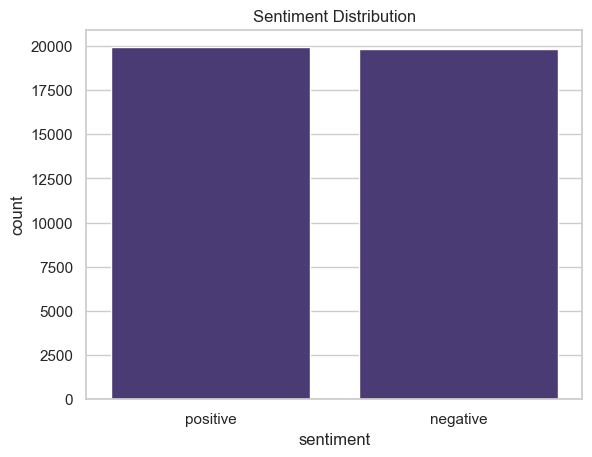

In [10]:
sns.countplot(x='sentiment', data=train)
plt.title('Sentiment Distribution')

As you can see we got almost same amount of positive and negative reviews, which is really good, because our model will learn much better this way

Text(0, 0.5, 'Frequency')

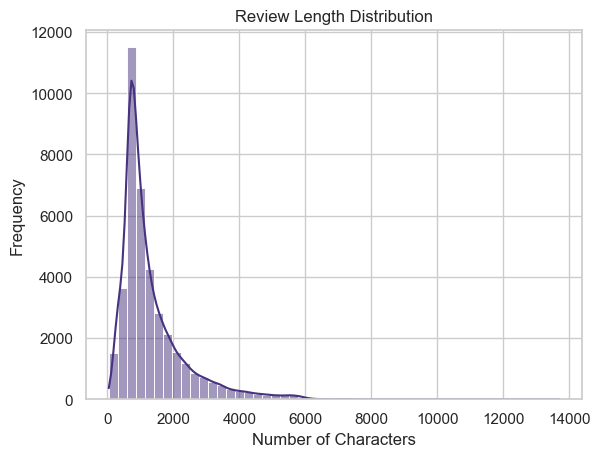

In [11]:
train['reviewlength'] = train['review'].apply(len)

sns.histplot(train['reviewlength'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

So we have a normal distribution that has a positive skew. Plot shows that most of the reviews have around 1000 characters in it and some has as high as 6000. Let's now check the boxplot for the better outlier visualization.

Text(0.5, 1.0, 'Review Length by Sentiment')

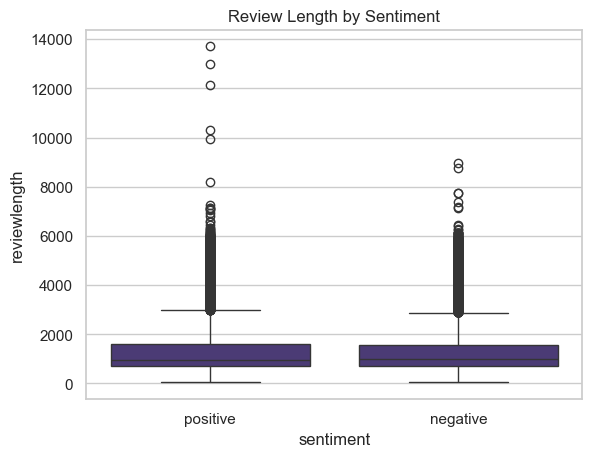

In [12]:
sns.boxplot(x='sentiment', y='reviewlength', data=train)
plt.title('Review Length by Sentiment')

Boxplot helps us visualize those outliers much better. As you can see boxplot showed us those few outliers that weren't visible on the distplot. As it turns out there are few reviews with positive sentiment that hit as high as 14,000 characters, which is quite a high number, but since there are so few of them we can keep them as it is.

Text(0, 0.5, 'Average Number of Characters')

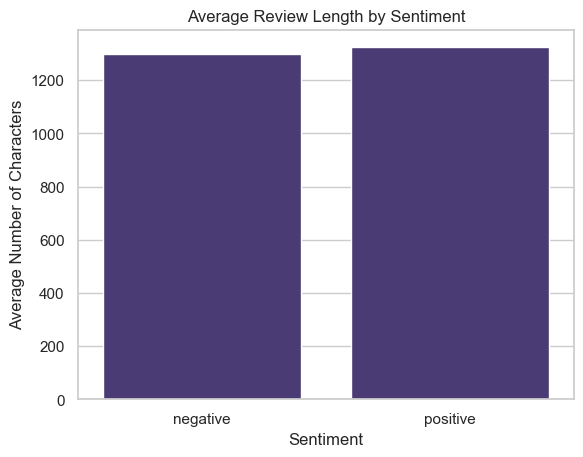

In [13]:
avg_length = train.groupby('sentiment')['reviewlength'].mean().reset_index()

sns.barplot(x='sentiment', y='reviewlength', data=avg_length)
plt.title('Average Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Number of Characters')

So there is not much to deduct in terms of word and sentiment correlation, because both negative and positive reviews have almost the same average word counts

(np.float64(-0.5), np.float64(1199.5), np.float64(599.5), np.float64(-0.5))

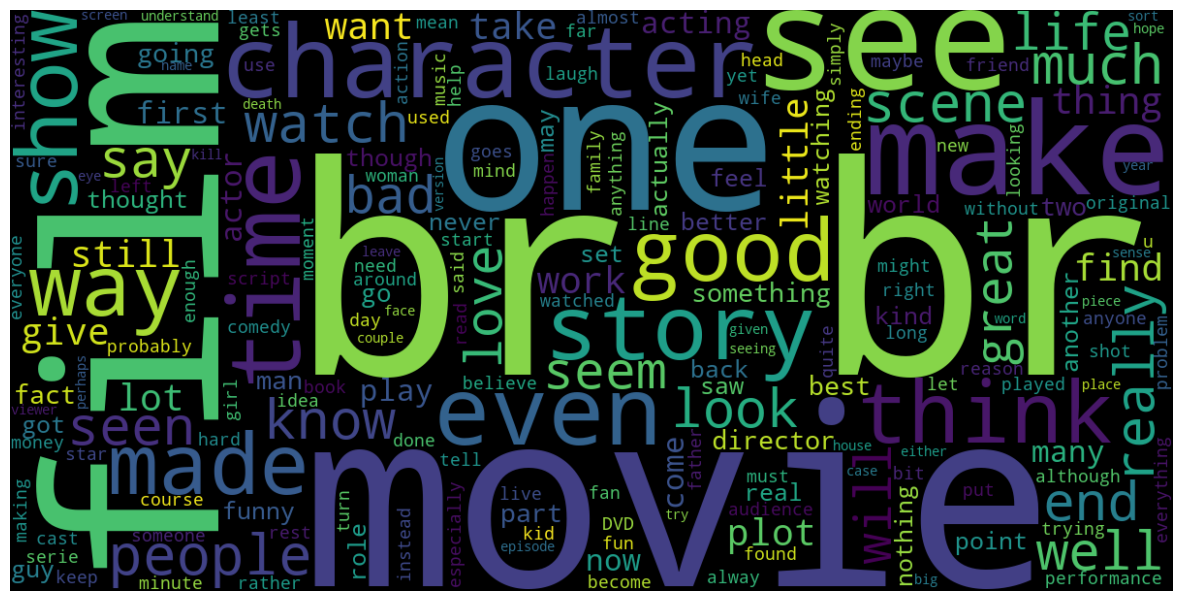

In [14]:
wordcloud = WordCloud(width=1200, height=600).generate(' '.join(train['review']))
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

Here is a cool picture of the most frequently used words in reviews. These br's most definitely are the part of HTML tags, which I will get rid of soon.

To sum it up, we didn't really find any abnormalities in the train dataset, everything seems to be alright. Duplicates have taken care of, there are no null values and the target binary column is well balance. We are fully ready to move to the next step, which is text preprocessing, getting it ready to train the model afterwards

# Data Preprocessing

Let's create data preprocessing functions for the pipeline step-by-step, starting with basic data cleaning

In [15]:
def basic_cleaning(text):

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove emojis
    text = emoji.replace_emoji(text, replace='')

    # Remove emoticons
    text = re.sub(r'[:;=8]?-?[)D]', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    return text

I know there are further advanced and useful data cleaning methods, such as frequent words removal or one of the most useful, spell checkers. But since we have to do some experimenting later on, we will have to execute all these steps on every single experiment on different methods to find the best performer, including spell checker or frequent word removal in this function would make those processes much much slower and time consuming. I believe that we can still achieve the desired accuracy with our models even tho we lack some of the cleaning processes.

Now let's make the tokenizer and the stopwords removal

In [16]:
def tokenize_text(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

Time to create a function, which will yield both stemming and lemmatization results for the further comparisons that we will do later

In [17]:
def stemming_and_lemmatization(tokens):

    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in tokens]

    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]

    return stemmed, lemmatized

Let's now make the final cleanance function that includes the steps above

In [18]:
def clean_text(text, apply_stemming=False):
    text = basic_cleaning(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)

    if apply_stemming:
        tokens = stemming_and_lemmatization(tokens)[0]
    else:
        tokens = stemming_and_lemmatization(tokens)[1]

    return ' '.join(tokens)

TIme to build 2 functions of 2 types of vectorization to compare them to each other into the actions later. I will be comparing the tfidf vectorization method to count vectorizer

In [19]:
def vectorize_tfidf(train, test):
    tfidf_vectorizer = TfidfVectorizer(max_features=10000)
    X_train = tfidf_vectorizer.fit_transform(train['cleaned_review'])
    X_test = tfidf_vectorizer.transform(test['cleaned_review'])
    return X_train, X_test, tfidf_vectorizer


def vectorize_count(train, test):
    count_vectorizer = CountVectorizer(max_features=10000)
    X_train = count_vectorizer.fit_transform(train['cleaned_review'])
    X_test = count_vectorizer.transform(test['cleaned_review'])
    return X_train, X_test, count_vectorizer

And finally, let's sum all this up and create a whole data preprocessor pipeline, which will yield all the necessary data to train and test the model and compare different types of preprocessing methods.

In [20]:
def preprocess_pipeline(train, test, apply_stemming=False):

    train['cleaned_review'] = train['review'].apply(clean_text)
    test['cleaned_review'] = test['review'].apply(clean_text)

    X_train_tfidf, X_test_tfidf, tfidf_vectorizer = vectorize_tfidf(train, test)
    X_train_count, X_test_count, count_vectorizer = vectorize_count(train, test)

    y_train = train['sentiment']
    y_test = test['sentiment']

    return X_train_tfidf, X_test_tfidf, X_train_count, X_test_count, y_train, y_test, tfidf_vectorizer, count_vectorizer


We got everything ready, the whole pipeline that will do every sufficient step to our train and test data and get them ready for othe model training and evaluation, now lets write a main execution block which will run the pipeline

In [21]:
if __name__ == "__main__":
    # We can set True to apply stemming, False for lemmatization
    apply_stemming = False

    X_train_tfidf, X_test_tfidf, X_train_count, X_test_count, y_train, y_test, tfidf_vectorizer, count_vectorizer = preprocess_pipeline(train, test, apply_stemming)


Since we done with preprocessing, it's time to build variety of models and evaluate their performances

# Model Experimenting

Before we dive into the different types of models and find out their performances, let's firstly find out the best combination of word reduction and vectorization techniques. We have two types of both of them: Lemmatization and Stemming for word reduction, count and tfidf for vectorization, which means we got 4 possible pairs. Let's try out all these possible pairs on our choice of baseline model, which in this case is naive bayes, and find out the best performers, so we can use them for more advanced classification models later.

In [22]:
label_mapping = {'negative': 0, 'positive': 1}

def convert_labels(y):
    return list(map(lambda x: label_mapping[x], y))

def train_and_evaluate(X_train, X_test, y_train, y_test):

    y_train_numeric = convert_labels(y_train)
    y_test_numeric = convert_labels(y_test)

    model = MultinomialNB()
    model.fit(X_train, y_train_numeric)

    y_pred = model.predict(X_test)
    print("Naive Bayes - Classification Report:\n")
    print(classification_report(y_test_numeric, y_pred))

def run_experiments(train, test):
    # Experiment 1: Stemming + Count Vectorizer
    print("\nExperiment 1: Stemming + Count Vectorizer")
    X_train_tfidf, X_test_tfidf, X_train_count, X_test_count, y_train, y_test, tfidf_vectorizer, count_vectorizer = preprocess_pipeline(train, test, apply_stemming=True)
    train_and_evaluate(X_train_count, X_test_count, y_train, y_test)

    # Experiment 2: Stemming + TF-IDF
    print("\nExperiment 2: Stemming + TF-IDF")
    train_and_evaluate(X_train_tfidf, X_test_tfidf, y_train, y_test)

    # Experiment 3: Lemmatization + Count Vectorizer
    print("\nExperiment 3: Lemmatization + Count Vectorizer")
    X_train_tfidf, X_test_tfidf, X_train_count, X_test_count, y_train, y_test, tfidf_vectorizer, count_vectorizer = preprocess_pipeline(train, test, apply_stemming=False)
    train_and_evaluate(X_train_count, X_test_count, y_train, y_test)

    # Experiment 4: Lemmatization + TF-IDF
    print("\nExperiment 4: Lemmatization + TF-IDF")
    train_and_evaluate(X_train_tfidf, X_test_tfidf, y_train, y_test)

if __name__ == "__main__":
    run_experiments(train, test)


Experiment 1: Stemming + Count Vectorizer
Naive Bayes - Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      5000
           1       0.85      0.84      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Experiment 2: Stemming + TF-IDF
Naive Bayes - Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5000
           1       0.85      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


Experiment 3: Lemmatization + Count Vectorizer
Naive Bayes - Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      5000

Okay so as it turns out Lemmatization and Stemming have the same results, but the TF-IDF happens to be a better performer than the count verctorizer so we will be sticking to it in the next model trainings. Our best results as a untuned baseline model is 0.86 accuracy, which is neither bad nor horrible, but I am sure we can get much better accuracy with other tuned models. Let's now do the logistic regression with little bit of tuning and find out how it will perform

In [23]:
def train_and_evaluate_logistic_regression(X_train, X_test, y_train, y_test):
    y_train_numeric = convert_labels(y_train)
    y_test_numeric = convert_labels(y_test)

    model = LogisticRegression(max_iter=1000)

    param_grid = {
        'C': [0.1, 1, 2, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'saga']
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

    grid_search.fit(X_train, y_train_numeric)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Logistic Regression - Classification Report:\n")
    print(classification_report(y_test_numeric, y_pred))

print("\nTraining Logistic Regression with Stemming + TF-IDF and Hyperparameter Tuning")
X_train_tfidf, X_test_tfidf, _, _, y_train, y_test, tfidf_vectorizer, _ = preprocess_pipeline(train, test, apply_stemming=True)

train_and_evaluate_logistic_regression(X_train_tfidf, X_test_tfidf, y_train, y_test)


Training Logistic Regression with Stemming + TF-IDF and Hyperparameter Tuning
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Hyperparameters: {'C': 2, 'penalty': 'l2', 'solver': 'saga'}
Logistic Regression - Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Okay as I thought, our tuned logistic regression performs much better than the Naive Bayes, yielding the 0.89 accuracy, which is pretty decent. Let's now try our third and last model, XGBoost, tune it a litte bit and find out the best performer out of all

In [24]:
def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test):
    y_train_numeric = convert_labels(y_train)
    y_test_numeric = convert_labels(y_test)

    model = XGBClassifier(eval_metric='logloss')

    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.3]
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train_numeric)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"XGBoost - Classification Report:\n")
    print(classification_report(y_test_numeric, y_pred))

print("\nTraining XGBoost with Stemming + TF-IDF and Hyperparameter Tuning")
train_and_evaluate_xgboost(X_train_tfidf, X_test_tfidf, y_train, y_test)


Training XGBoost with Stemming + TF-IDF and Hyperparameter Tuning
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}
XGBoost - Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      5000
           1       0.84      0.87      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



So as expected, tree based models are not the best choice in terms of binary sentiment analysis, XGBoost resulted 0.85 accuracy, which is not a disaster, but Logistic Regression is the optimal choice in our case with the best out of 3 models with 0.89 accuracy. 